#Zadanie 7 (7 pkt) Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.

W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.

W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów. Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - 0.5 pkt
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - 0.5 pkt
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - 2.0 pkt
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - 2.5 pkt
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - 1.5 pkt

In [64]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [76]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        class_counts = Counter(train_classes)
        for class_val, count in class_counts.items():
            self.priors[class_val] = count / len(train_classes)

        self.likelihoods = {}
        for class_val in set(train_classes):
            self.likelihoods[class_val] = {}
            for i in range(train_features.shape[1]):
                self.likelihoods[class_val][i] = Counter(train_features[train_classes == class_val, i])

    @staticmethod
    def data_discretization(data, bins):
        return np.digitize(data, np.histogram_bin_edges(data, bins=bins))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, sample):
        epsilon = 2e-32
        max_prob = -np.inf
        max_class = None
        for class_val in self.priors.keys():
            prob = np.log(self.priors[class_val])
            for i, val in enumerate(sample):
                prob += np.log(self.likelihoods[class_val][i][val] / sum(self.likelihoods[class_val][i].values()) + epsilon)
            if prob > max_prob:
                max_prob = prob
                max_class = class_val
        return max_class


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        class_counts = Counter(train_classes)
        for class_val, count in class_counts.items():
            self.priors[class_val] = count / len(train_classes)

        self.likelihoods = {}
        for class_val in set(train_classes):
            self.likelihoods[class_val] = {}
            for i in range(train_features.shape[1]):
                self.likelihoods[class_val][i] = {"mean": np.mean(train_features[train_classes == class_val, i]),
                                                  "std": np.std(train_features[train_classes == class_val, i])}

    @staticmethod
    def normal_dist(x, mean, std):
        if not std:
            std = 2e-32
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x - mean) ** 2 / (2 * std ** 2)))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, sample):
        epsilon = 2e-32
        max_prob = -np.inf
        max_class = None
        for class_val in self.priors.keys():
            prob = np.log(self.priors[class_val])
            for i, val in enumerate(sample):
                prob += np.log(self.normal_dist(val, self.likelihoods[class_val][i]["mean"],
                                                self.likelihoods[class_val][i]["std"]) + epsilon)
            if prob > max_prob:
                max_prob = prob
                max_class = class_val
        return max_class

# TESTY

In [51]:
iris = load_iris()

x = iris.data
y = iris.target

seeds = [404, 123, 42, 213, 777, 235, 214, 534, 321, 1]
test_sizes = [i/10 for i in range(1, 10)]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [52]:
def test_accuracy(nb, x_test, y_test):
    predictions = nb.predict(x_test)
    accuracy = np.sum(predictions == y_test) / len(y_test)
    return accuracy


# Dyskretyzacja danych

In [62]:
nb = NaiveBayes()

x_discretized = NaiveBayes.data_discretization(x, 4)
x_train, x_test, y_train, y_test = train_test_split(x_discretized, y, test_size=0.1, random_state=123)

nb.build_classifier(x_train, y_train)
print(test_accuracy(nb, x_test, y_test))

0.9333333333333333


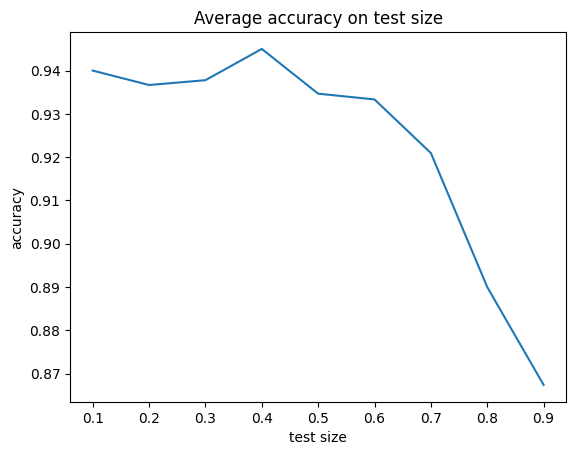

In [71]:
avg_accuracies = {}
x_discretized = NaiveBayes.data_discretization(x, 4)
for test_size in test_sizes:
    accuracy = 0
    for seed in seeds:
        nb = NaiveBayes()
        x_train, x_test, y_train, y_test = train_test_split(x_discretized, y, test_size=test_size, random_state=seed)
        nb.build_classifier(x_train, y_train)
        accuracy += test_accuracy(nb, x_test, y_test)
    avg_accuracies[test_size] = accuracy / len(seeds)

plt.plot(avg_accuracies.keys(), avg_accuracies.values())
plt.title("Average accuracy on test size")
plt.xlabel("test size")
plt.ylabel("accuracy")
plt.show()



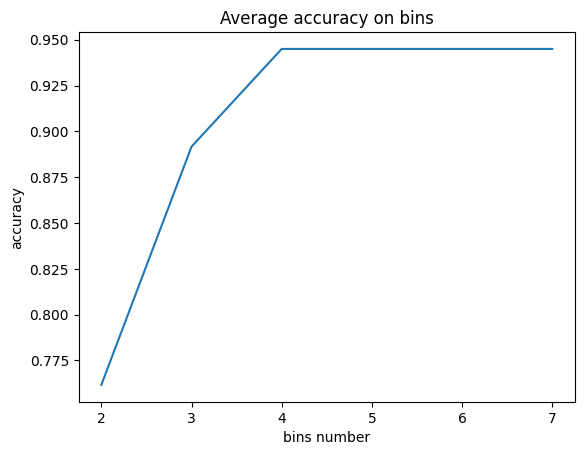

In [81]:
avg_accuracies = {}
bins = [2, 3, 4, 5, 6, 7]
for bin in bins:
    accuracy = 0
    for seed in seeds:
        nb = NaiveBayes()
        x_discretized = NaiveBayes.data_discretization(x, bin)
        x_train, x_test, y_train, y_test = train_test_split(x_discretized, y, test_size=0.4, random_state=seed)
        nb.build_classifier(x_train, y_train)
        accuracy += test_accuracy(nb, x_test, y_test)
    avg_accuracies[bin] = accuracy / len(seeds)

plt.plot(avg_accuracies.keys(), avg_accuracies.values())
plt.title("Average accuracy on bins")
plt.xlabel("bins number")
plt.ylabel("accuracy")
plt.show()

# Rozkład normalny

In [ ]:
nb = GaussianNaiveBayes()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

nb.build_classifier(x_train, y_train)
print(accuracy(nb, x_test, y_test))

1.0


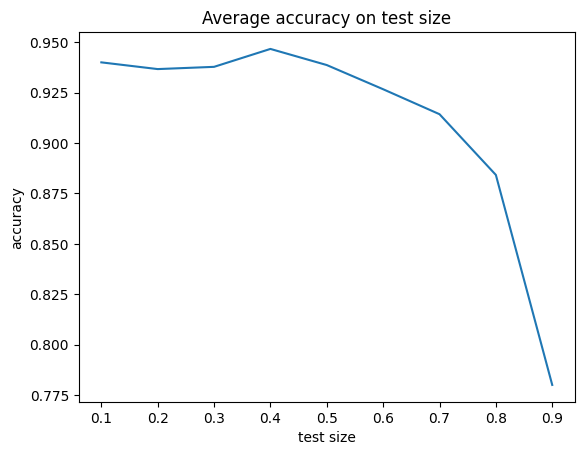

In [77]:
avg_accuracies = {}
for test_size in test_sizes:
    accuracy = 0
    for seed in seeds:
        nb = GaussianNaiveBayes()
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
        nb.build_classifier(x_train, y_train)
        accuracy += test_accuracy(nb, x_test, y_test)
    avg_accuracies[test_size] = accuracy / len(seeds)

plt.plot(avg_accuracies.keys(), avg_accuracies.values())
plt.title("Average accuracy on test size")
plt.xlabel("test size")
plt.ylabel("accuracy")
plt.show()